# Retro Plots for Spring 2017 Collaboration Meeting
These plots were made for Philipp to put together a presentation for the Fall 2017 IceCube collaboration meeting.
The final presentation is at
https://events.icecube.wisc.edu/contributionDisplay.py?contribId=40&sessionId=22&confId=90

In [1]:
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from glob import glob
import os
from os.path import abspath, dirname, expanduser, expandvars, join
import sys
import time

import matplotlib.ticker as ticker
import matplotlib.colors as colors
import numpy as np

from plotGoodies import removeBorder

os.sys.path.append(expanduser('~/src/retro')) #dirname(dirname(abspath(__file__))))
from retro import Event, HypoParams8D, expand
from retro import (event_to_hypo_params, extract_photon_info,
                   powerspace, spherical_volume)
from retro.discrete_hypo import DiscreteHypo
from retro.discrete_cascade_kernels import point_cascade
from retro.discrete_muon_kernels import const_energy_loss_muon
from retro.events import Events
from retro.likelihood import get_neg_llh, scan
from retro.table_readers import DOMTimePolarTables, TDICartTables

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

[ WARNING] /home/justin/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



PISA running in double precision (FP64) mode.


In [3]:
plot_dir = expand('~/src/retro/time_slices')

In [4]:
geom = np.load(expand('~/src/retro/retro/data/geo_array.npy'))

In [5]:
string = 36
dom = 49
center = geom[string - 1, dom, :]
dom_x, dom_y, dom_z = center
print center

[  46.29000092  -34.88000107 -333.04000854]


## Single-DOM table animation
Create frames of an animation of a single DOM table. This actually makes use of TDI tables, which were generated by selecting a single DOM at a single time. (See shell command below for generating the tables, and following the frame generation, the shell command for combining the frames into a GIF animation.)

### Generate single-time/single-DOM TDI tables

In [ ]:
%%bash

condaenv

for t in {0..299}
do
    ~/src/retro/retro/generate_time_and_dom_indep_tables.py \
        --tables-dir /fastio/icecube/retro_tables/full1000 \
        --geom-fpath ~/src/retro/retro/data/geo_array.npy \
        --n-phibins 80 \
        --x-lims -55 145 \
        --y-lims -135 65 \
        --z-lims -435 -235 \
        --binwidth 0.5 \
        --oversample 1 \
        --antialias 1 \
        --ic-scale 1 \
        --dc-scale 1 \
        --strings 36 \
        --depths 49 \
        --times $t
done

### Generate frames (plots)

In [160]:
for tidx in range(299, -1, -1):
    print tidx
    tables_dir = '/fastio/icecube/retro_tables/full1000'
    fname_proto = (
        'retro_tdi_table_*'
        '_binmap_09b98dbfc518d894'
        '_geom_5caf2937eaaf66cc'
        '_domtbl_none'
        '_times_%d'
        '_x-55.000_145.000_y-135.000_65.000_z-435.000_-235.000'
        '_bw0.500000000'
        '_anisot_none'
        '_ics1.00000_dcs1.00000'
        '_avg_photon_z'
        '.fits' % tidx
    )
    try:
        fname = glob(join(tables_dir, fname_proto))[0]
    except:
        raise
        #continue
    meta = TDICartTables.get_table_metadata(fname)
    tdi = TDICartTables(
        tables_dir=tables_dir,
        use_directionality=True,
        proto_tile_hash=meta['tdi_hash'],
        scale=1,
    )
    
    # Number of macro cells to look at in any direction from the dom
    # (this will include any subcells due to oversampling)
    nbins = 50
    
    x_os_bw = tdi.binwidth
    y_os_bw = tdi.binwidth
    z_os_bw = tdi.binwidth

    dom_x_idx = np.floor((center[0] - tdi.x_min) / tdi.binwidth).astype(int)
    dom_y_idx = np.floor((center[1] - tdi.y_min) / tdi.binwidth).astype(int)
    dom_z_idx = np.floor((center[2] - tdi.z_min) / tdi.binwidth).astype(int)
    print dom_x_idx, dom_y_idx, dom_z_idx 

    dom_x_os_idx = dom_x_idx
    dom_y_os_idx = dom_y_idx
    dom_z_os_idx = dom_z_idx
    
    x_oversample = 1
    y_oversample = 1
    
    for slice_dims in ['xy', 'xz']:
        # Formulate a slice through the table to look at
        slx = slice(dom_x_idx - nbins,
                    dom_x_idx + nbins + 1,
                    1)
        sly = slice(dom_y_idx - nbins,
                    dom_y_idx + nbins + 1,
                    1)
        slz = slice(dom_z_idx - nbins,
                    dom_z_idx + nbins + 1,
                    1)
        if slice_dims == 'xy':
            slz = dom_z_idx
        elif slice_dims == 'xz':
            sly = dom_y_idx
        elif slice_dims == 'yz':
            slx = dom_x_idx
        sl = (slx, sly, slz)
        
        xlims = tdi.x_min, tdi.x_max
        ylims = tdi.y_min, tdi.y_max
        zlims = tdi.z_min, tdi.z_max
        
        xedges0 = tdi.x_min + (dom_x_idx - nbins) * tdi.binwidth
        xedges1 = tdi.x_min + (dom_x_idx + nbins + 1) * tdi.binwidth
        
        yedges0 = tdi.y_min + (dom_y_idx - nbins) * tdi.binwidth
        yedges1 = tdi.y_min + (dom_y_idx + nbins + 1) * tdi.binwidth
        
        zedges0 = tdi.z_min + (dom_z_idx - nbins) * tdi.binwidth
        zedges1 = tdi.z_min + (dom_z_idx + nbins + 1) * tdi.binwidth
        
        xedges = np.linspace(xedges0, xedges1, nbins*2 + 2)
        yedges = np.linspace(yedges0, yedges1, nbins*2 + 2)
        zedges = np.linspace(zedges0, zedges1, nbins*2 + 2)
        
        # Grab avg photon slices
        pxsl = tdi.avg_photon_x[sl]
        pysl = tdi.avg_photon_y[sl]
        pzsl = tdi.avg_photon_z[sl]
        
        ppsl = tdi.survival_prob[sl]
        
        xmid = np.squeeze((xlims[0] + tdi.binwidth/2.0 + tdi.binwidth * np.arange(tdi.nx))[slx])
        ymid = np.squeeze((ylims[0] + tdi.binwidth/2.0 + tdi.binwidth * np.arange(tdi.ny))[sly])
        zmid = np.squeeze((zlims[0] + tdi.binwidth/2.0 + tdi.binwidth * np.arange(tdi.nz))[slz])
        
        x_inner_lim = (xmid.min() - tdi.binwidth/2.0, xmid.max() + tdi.binwidth/2.0)
        y_inner_lim = (ymid.min() - tdi.binwidth/2.0, ymid.max() + tdi.binwidth/2.0)
        z_inner_lim = (zmid.min() - tdi.binwidth/2.0, zmid.max() + tdi.binwidth/2.0)
        
        if slice_dims == 'xy':
            X, Y = np.meshgrid(xmid, ymid, indexing='ij')
            XX, YY = np.meshgrid(xedges, yedges, indexing='ij')
            xlim = x_inner_lim
            ylim = y_inner_lim
            px = pxsl
            py = pysl
        elif slice_dims == 'xz':
            X, Y = np.meshgrid(xmid, zmid, indexing='ij')
            XX, YY = np.meshgrid(xedges, zedges, indexing='ij')
            xlim = x_inner_lim
            ylim = z_inner_lim
            px = pxsl
            py = pzsl
        elif slice_dims == 'yz':
            X, Y = np.meshgrid(ymid, zmid, indexing='ij')
            XX, YY = np.meshgrid(yedges, zedges, indexing='ij')
            xlim = y_inner_lim
            ylim = z_inner_lim
            px = pysl
            py = pzsl
            
        fig = plt.figure(figsize=(7, 5), dpi=72)
        fig.clf()
        ax = fig.add_subplot(111)
       
        vmin = 1e-7
        vmax = 1e-3
        pc1 = ax.pcolormesh(
            XX, YY, np.clip(ppsl, a_min=vmin, a_max=vmax),
            cmap='viridis', shading='flat',
            #vmin=1e-6, vmax=1e-3,
            norm=colors.LogNorm(vmin=vmin, vmax=vmax)
        )
        
        #ax.plot(
        #    dom_x, dom_y,
        #    'ro', ms=2, lw=0.5,
        #    label='DOM location'
        #)
        #ax.plot(
        #    xlims[0] + x_os_bw*dom_x_os_idx,
        #    ylims[0] + y_os_bw*dom_y_os_idx,
        #    'go', ms=4, lw=0.5,
        #    label='DOM location used for binning'
        #)
        
        ax.quiver(
            X, Y, px, py,
            scale=10,
            width=0.002,
            color=(1, 0.1, 0.1),
            label='Average photon direction'
        )
        
        ax.axis('image')
        ax.set_xlabel('%s (m)' % slice_dims[0])
        ax.set_ylabel('%s (m)' % slice_dims[1])
        
        #ax.set_xticks(np.arange(xlims[0], xlims[1]+tdi.binwidth, tdi.binwidth), minor=False)
        #ax.grid(which='major', b=True)
        #if x_oversample > 1:
        #    ax.set_xticks(
        #        np.arange(x_inner_lim[0]+x_os_bw, x_inner_lim[1], x_os_bw),
        #        minor=True
        #    )
        #    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
        #    
        #if y_oversample > 1:
        #    ax.set_yticks(
        #        np.arange(y_inner_lim[0]+y_os_bw, y_inner_lim[1], y_os_bw),
        #        minor=True
        #    )
        #    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
            
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #ax.legend(loc='upper left', fancybox=True, framealpha=0.9)
        ax.set_title('Detail of single-DOM table, %s-slice through DOM (%d, %d)'
                     % (slice_dims.upper(), string, dom))
        cb = plt.colorbar(pc1) #, format='%.1e')
        cb.set_label('Survival probability')
        
        fig.tight_layout()
        
        fbasename = join(plot_dir, 'slice_detail_%s_t%s' % (slice_dims, tidx))
        fig.savefig(fbasename + '.png' , dpi=300, transparent=False)
        #fig.savefig(fbasename + '.pdf')
        plt.close(fig.number)

pass

299
Loaded 1 tile spanning x ∈ [-55.00, 145.00) m, y ∈ [-135.00, 65.00) m, z ∈ [-435.00, -235.00) m; bins are (0.500 m)³
Time to load: 3.758 s
298
Loaded 1 tile spanning x ∈ [-55.00, 145.00) m, y ∈ [-135.00, 65.00) m, z ∈ [-435.00, -235.00) m; bins are (0.500 m)³
Time to load: 3.942 s
297
Loaded 1 tile spanning x ∈ [-55.00, 145.00) m, y ∈ [-135.00, 65.00) m, z ∈ [-435.00, -235.00) m; bins are (0.500 m)³
Time to load: 4.004 s
296
Loaded 1 tile spanning x ∈ [-55.00, 145.00) m, y ∈ [-135.00, 65.00) m, z ∈ [-435.00, -235.00) m; bins are (0.500 m)³
Time to load: 3.907 s
295
Loaded 1 tile spanning x ∈ [-55.00, 145.00) m, y ∈ [-135.00, 65.00) m, z ∈ [-435.00, -235.00) m; bins are (0.500 m)³
Time to load: 3.915 s
294
Loaded 1 tile spanning x ∈ [-55.00, 145.00) m, y ∈ [-135.00, 65.00) m, z ∈ [-435.00, -235.00) m; bins are (0.500 m)³
Time to load: 3.904 s
293
Loaded 1 tile spanning x ∈ [-55.00, 145.00) m, y ∈ [-135.00, 65.00) m, z ∈ [-435.00, -235.00) m; bins are (0.500 m)³
Time to load: 3.950 s

### Combine frames into an animation

In [29]:
os.environ['plot_dir'] = plot_dir

In [33]:
%%time
%%bash

convert \
    -delay 80 \
    -loop 0 \
    -resize 50% \
    ${plot_dir}/slice_detail_xz_t{299..280}.png \
    ${plot_dir}/slice_detail_xz.gif
    
convert \
    -delay 80 \
    -loop 0 \
    -resize 50% \
    ${plot_dir}/slice_detail_xy_t{299..280}.png \
    ${plot_dir}/slice_detail_xy.gif

CPU times: user 0 ns, sys: 36 ms, total: 36 ms
Wall time: 24.7 s


## Plot whole-detector TDI table slices

### Load the whole-detector (all-DOMs) TDI table

In [6]:
%%time

tables_dir = '/fastio/icecube/retro_tables/full1000'

tdi1 = TDICartTables(
    tables_dir=tables_dir,
    use_directionality=True,
    proto_tile_hash="001cdf9fbd7ef81d",
    scale=1,
)

Loaded 2744 tiles spanning x ∈ [-700.00, 700.00) m, y ∈ [-700.00, 700.00) m, z ∈ [-800.00, 600.00) m; bins are (1.000 m)³
Time to load: 01:14.120
CPU times: user 42.8 s, sys: 26.5 s, total: 1min 9s
Wall time: 1min 14s


### Global coordinate computations

In [7]:
%%time

xlims = tdi1.x_min, tdi1.x_max
ylims = tdi1.y_min, tdi1.y_max
zlims = tdi1.z_min, tdi1.z_max

xedges = np.linspace(tdi1.x_min, tdi1.x_max, tdi1.nx + 1)
yedges = np.linspace(tdi1.y_min, tdi1.y_max, tdi1.ny + 1)
zedges = np.linspace(tdi1.z_min, tdi1.z_max, tdi1.nz + 1)

xmid = np.squeeze((xlims[0] + tdi1.binwidth/2.0 + tdi1.binwidth * np.arange(tdi1.nx)))
ymid = np.squeeze((ylims[0] + tdi1.binwidth/2.0 + tdi1.binwidth * np.arange(tdi1.ny)))
zmid = np.squeeze((zlims[0] + tdi1.binwidth/2.0 + tdi1.binwidth * np.arange(tdi1.nz)))

#proj_sp_xy = 1 - (1 - tdi1.survival_prob).prod(axis=2)
#proj_sp_xz = 1 - (1 - tdi1.survival_prob).prod(axis=1)
#proj_sp_yz = 1 - (1 - tdi1.survival_prob).prod(axis=0)
proj_sp_xy = tdi1.survival_prob.mean(axis=2)
proj_sp_xz = tdi1.survival_prob.mean(axis=1)
proj_sp_yz = tdi1.survival_prob.mean(axis=0)

CPU times: user 3.38 s, sys: 200 ms, total: 3.58 s
Wall time: 3.59 s


### Make the plots

saving /home/justin/src/retro/time_slices/slice_tdi_wholedet_xy_nodir.png ...
done.
saving /home/justin/src/retro/time_slices/slice_tdi_wholedet_xy_nodir.pdf ...
done.
saving /home/justin/src/retro/time_slices/slice_tdi_wholedet_xz_nodir.png ...
done.
saving /home/justin/src/retro/time_slices/slice_tdi_wholedet_xz_nodir.pdf ...
done.
saving /home/justin/src/retro/time_slices/slice_tdi_wholedet_xy_dir.png ...
done.
saving /home/justin/src/retro/time_slices/slice_tdi_wholedet_xy_dir.pdf ...
done.
saving /home/justin/src/retro/time_slices/slice_tdi_wholedet_xz_dir.png ...
done.
saving /home/justin/src/retro/time_slices/slice_tdi_wholedet_xz_dir.pdf ...
done.
CPU times: user 10.4 s, sys: 28 ms, total: 10.4 s
Wall time: 11.4 s


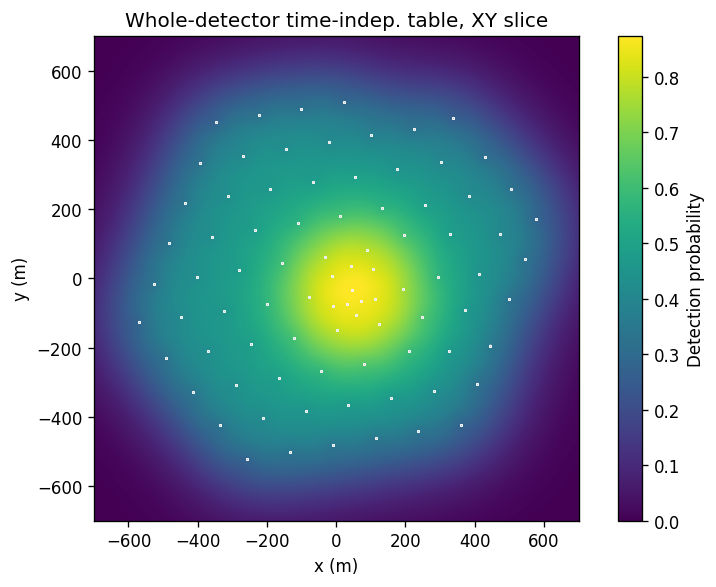

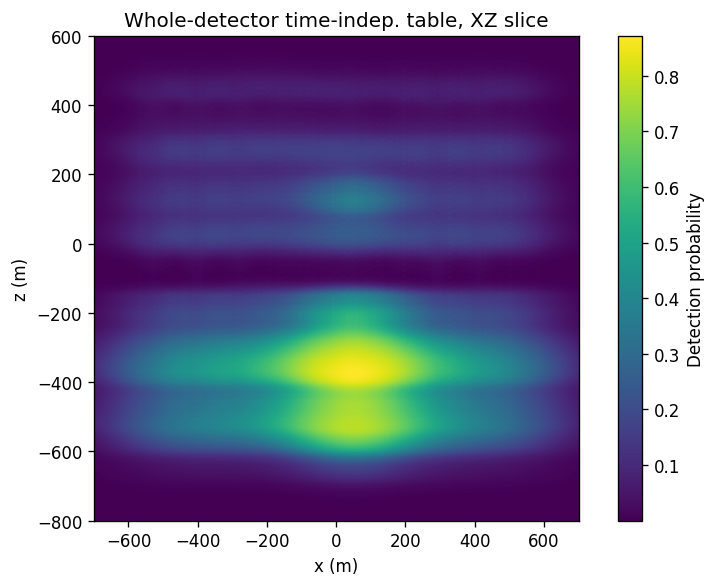

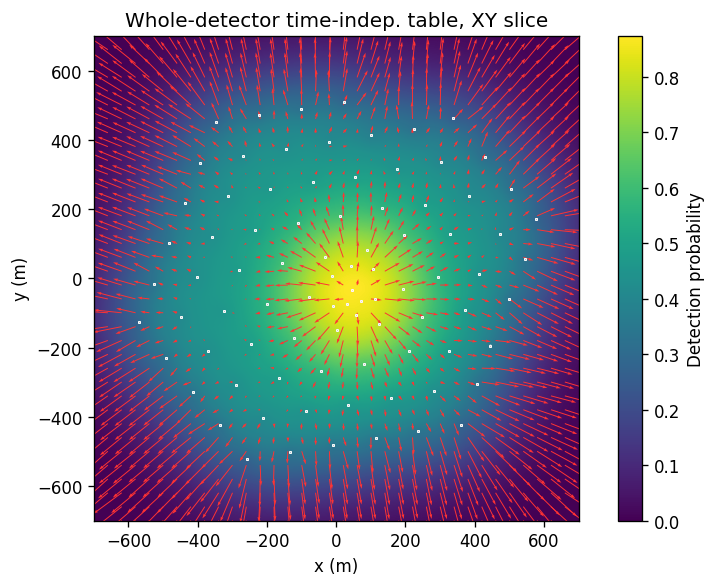

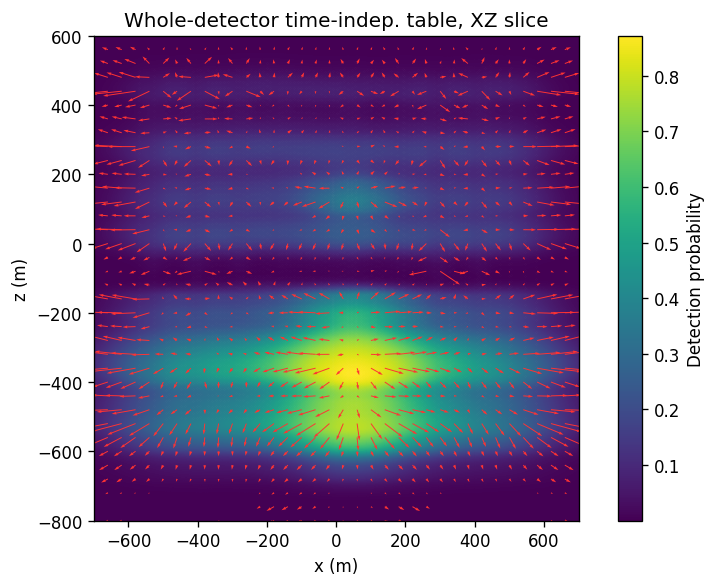

In [11]:
%%time

ss = 40
subsamp = slice(None, None, ss), slice(None, None, ss)

for plot_arrows in [False, True]:
    for slice_dims in ['xy', 'xz']:
        if slice_dims == 'xy':
            sl = slice(None), slice(None), 415
            sp_slice = tdi1.survival_prob[sl]
            #mask = mask_xy
            px = tdi1.avg_photon_x[sl][subsamp]
            py = tdi1.avg_photon_y[sl][subsamp]
            xlim = xlims
            ylim = ylims
            X, Y = np.meshgrid(xmid, ymid, indexing='ij')
            XX, YY = np.meshgrid(xedges, yedges, indexing='ij')
            dom_x = geom[:, :, 0].flatten()
            dom_y = geom[:, :, 1].flatten()
            dom_ms = 0.1
        elif slice_dims == 'xz':
            sl = slice(None), 700, slice(None)
            sp_slice = tdi1.survival_prob[sl]
            px = tdi1.avg_photon_x[sl][subsamp]
            py = tdi1.avg_photon_z[sl][subsamp]
            #mask = mask_xz
            xlim = xlims
            ylim = zlims
            X, Y = np.meshgrid(xmid, zmid, indexing='ij')
            XX, YY = np.meshgrid(xedges, zedges, indexing='ij')
            dom_x = geom[:, :, 0].flatten()
            dom_y = geom[:, :, 2].flatten()
            dom_ms = 0.01
        elif slice_dims == 'yz':
            sl = 700, slice(None), slice(None)
            sp_slice = tdi1.survival_prob[sl]
            px = tdi1.avg_photon_y[sl][subsamp]
            py = tdi1.avg_photon_z[sl][subsamp]
            #mask = mask_yz
            xlim = ylims
            ylim = zlims
            X, Y = np.meshgrid(ymid, zmid, indexing='ij')
            XX, YY = np.meshgrid(yedges, zedges, indexing='ij')
            dom_x = geom[:, :, 1].flatten()
            dom_y = geom[:, :, 2].flatten()
            dom_ms = 0.01
    
        fig = plt.figure(figsize=(7, 5), dpi=120)
        fig.clf()
        ax = fig.add_subplot(111)
        
        vmin = -np.inf
        vmax = np.inf
        pc1 = ax.pcolormesh(
            XX, YY, np.clip(sp_slice, a_min=vmin, a_max=vmax),
            cmap='viridis', shading='flat',
            rasterized=True, linewidth=0,
            #vmin=1e-6, vmax=1e-3,
            #norm=colors.LogNorm() #vmin=vmin, vmax=vmax)
        )
        pc1.set_edgecolor('face')
        
        #ax.plot(
        #    xlims[0] + x_os_bw*dom_x_os_idx,
        #    ylims[0] + y_os_bw*dom_y_os_idx,
        #    'go', ms=4, lw=0.5,
        #    label='DOM location used for binning'
        #)
   
        if plot_arrows:
            arrow_label = 'dir'
            mask = np.sqrt(px**2 + py**2) > 0.01
            ax.quiver(
                X[subsamp][mask], Y[subsamp][mask], px[mask], py[mask],
                scale=3,
                width=0.002,
                color=(1, 0.2, 0.2),
                label='Average photon direction'
            )
        else:
            arrow_label = 'nodir'
            
        ax.plot(
            dom_x, dom_y,
            'wo', ms=dom_ms, alpha=1.0,
            label='DOM locations'
        )
        
        ax.axis('image')
        ax.set_xlabel('%s (m)' % slice_dims[0])
        ax.set_ylabel('%s (m)' % slice_dims[1])
        
        #ax.set_xticks(np.arange(xlims[0], xlims[1]+tdi1.binwidth, tdi1.binwidth), minor=False)
        #ax.grid(which='major', b=True)
        #if x_oversample > 1:
        #    ax.set_xticks(
        #        np.arange(x_inner_lim[0]+x_os_bw, x_inner_lim[1], x_os_bw),
        #        minor=True
        #    )
        #    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
        #    
        #if y_oversample > 1:
        #    ax.set_yticks(
        #        np.arange(y_inner_lim[0]+y_os_bw, y_inner_lim[1], y_os_bw),
        #        minor=True
        #    )
        #    ax.grid(which='minor', b=True, ls=':', alpha=0.6)
            
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #ax.legend(loc='upper left', fancybox=True, framealpha=0.9)
        ax.set_title('Whole-detector time-indep. table, %s slice'
                     % slice_dims.upper())
        cb = plt.colorbar(pc1) #, format='%.1e')
        cb.set_label('Detection probability')
        
        fig.tight_layout()
        
        fbasename = join(plot_dir, 'slice_tdi_wholedet_%s_%s'
                         % (slice_dims, arrow_label))
        print 'saving', fbasename + '.png', '...'
        fig.savefig(fbasename + '.png' , dpi=300, transparent=False)
        print 'done.'
        print 'saving', fbasename + '.pdf', '...'
        fig.savefig(fbasename + '.pdf', dpi=300)
        print 'done.'
        #plt.close(fig.number)

pass

## Render $\LaTeX$ llh function

$${\rm llh} \equiv
\sum_{{\rm hit \, dom} \, i}\left[
    {\rm observed}_{i} \cdot \log({\rm expected}_{i})
    - \log \Gamma({\rm observed_{i}})
\right]
- {\rm total \, expected}$$